min_error:  6.445193780162587
min_error:  5.496101231917652
min_error:  4.668653873201875
min_error:  4.427843636089489
min_error:  3.920133823099714
min_error:  3.6728489520372394
min_error:  3.653999738377991
min_error:  3.6358367520187342
min_error:  3.616528780185061
min_error:  3.5650068131046293
min_error:  3.5197896352829097
min_error:  3.4670496462278524
min_error:  3.4197074411206563
min_error:  3.414631057731056
min_error:  3.302753653197774
min_error:  3.222037319633822
min_error:  3.1986155220317287
min_error:  3.1672706611168078
min_error:  3.1212132785698294
min_error:  3.106624921102379
min_error:  3.0806194400312243
min_error:  3.055246933037968
min_error:  3.038017173540845
min_error:  2.9385556995715802
min_error:  2.880962344128545
min_error:  2.8478503183814254
min_error:  2.8303676652762597
min_error:  2.823613450508882
min_error:  2.7087607689433657
min_error:  2.7047039148276615
min_error:  2.6810178189914495
min_error:  2.6343798596771504
min_error:  2.630594838

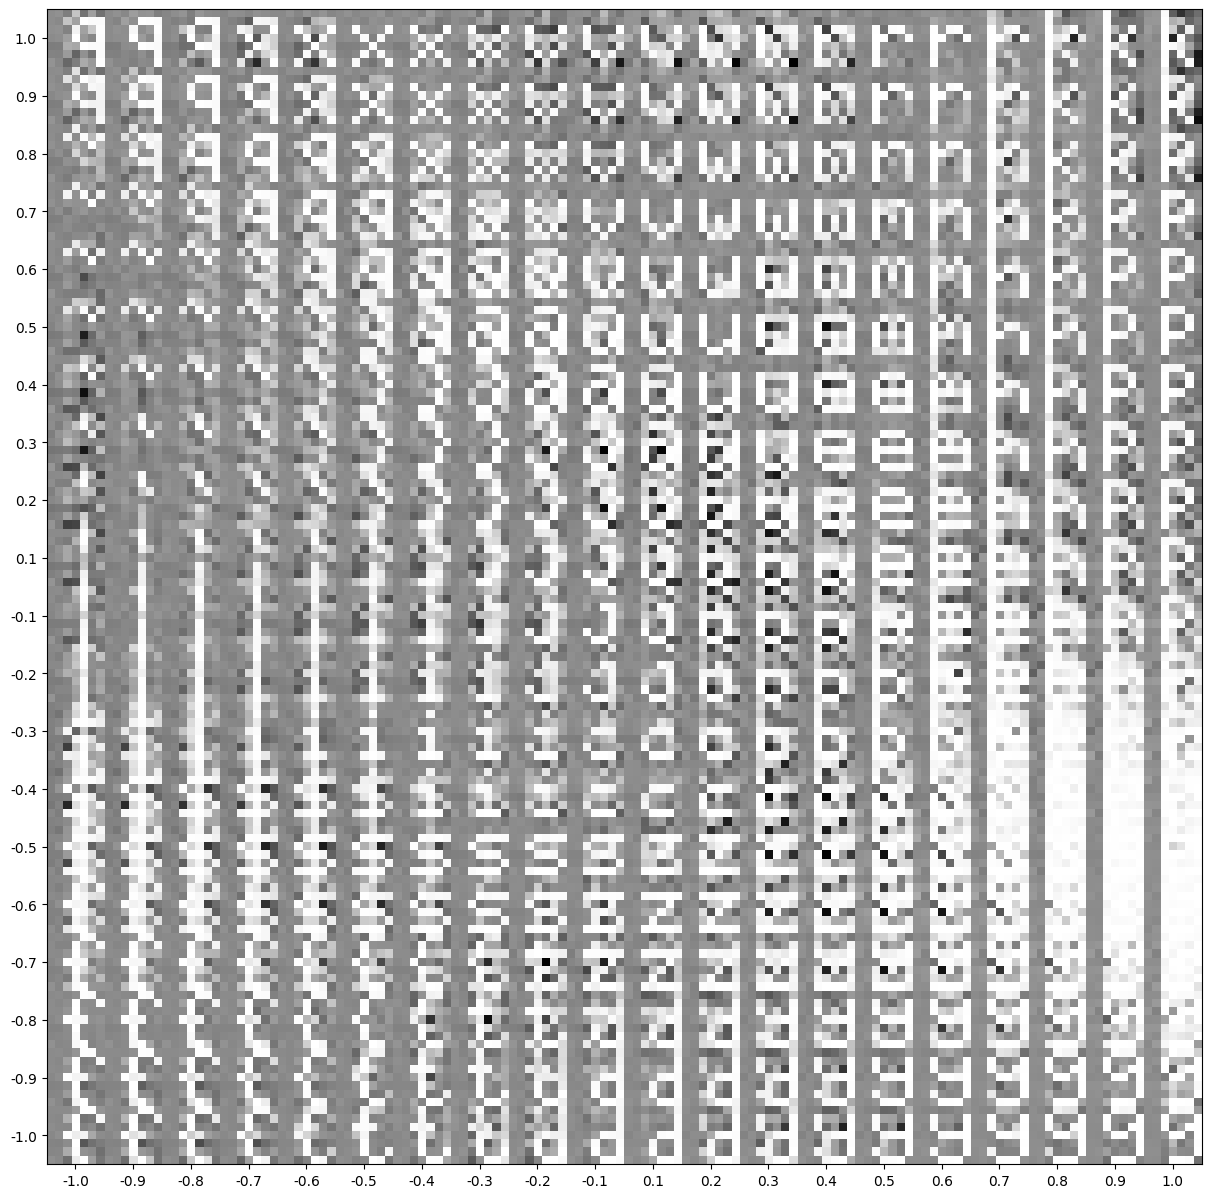

In [3]:
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import json
import numpy as np
import sys
import random

from condition import from_str as condition_from_str
from activation import from_str as activation_from_str
from error import from_str as error_from_str
from multilayerPerceptron import MultiLayerPerceptron
from optimizer import from_str as optimizer_from_str


def add_gaussian_noise(data, labels, stddev):
    if stddev == 0:
        return data, labels
    noisy_data = data + np.random.normal(0, stddev, data.shape)
    noisy_labels = labels + np.random.normal(0, stddev, labels.shape)
    return noisy_data, noisy_labels

def plot_latent_point(decoder, x, y, digit_size=7, fig_size=5):
    z = np.array([[x, y]])
    output = decoder.forward(z)
    digit = output.reshape(digit_size, digit_size)

    plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(digit, cmap="Greys_r")
    plt.title(f"Point in Latent Space: ({x}, {y})")
    plt.colorbar()

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig(f"plots/latentpoint{timestamp}.png")

def plot_latent(decoder, n=20, fig_size=15, digit_size=7):
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-1.0, 1.0, n)
    grid_y = np.linspace(-1.0, 1.0, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            output = decoder.forward(z)
            digit = output.reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(fig_size, fig_size))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig(f"plots/latent_{timestamp}.png")

def augment_training_data(data, labels, noise_stddev):
    noisy_data, noisy_labels = add_gaussian_noise(np.array(data), np.array(labels), noise_stddev)
    return np.concatenate((data, noisy_data)), np.concatenate((labels, noisy_labels))


def print_pixels_diff(mlp, data):
    print("Cantidad de pixeles diferentes por dato:")
    max_diff = 0
    for i in range(len(data)):
        obtained = mlp.forward(data[i])
        if i == 1:
           print(data[i], "\n", np.round(obtained), "\n\n")
        diff = 0
        for j in range(len(data[i])):
            diff += 1 if (data[i][j] != round(obtained[j])) else 0
        max_diff = max(max_diff,diff)
        # print(f"{i}: {diff} pixels")
    print(f"max_diff: {max_diff}\n")
    return max_diff


# Recibe la data y lo transforma en np's arrays de cada numero
def read_input(file, input_length):
    file1 = open(file, "r+")
    result = [(1 if character == '1' else 0) for character in file1.read().split()]
    result = np.array_split(result, len(result) / input_length)
    return result


def split_data(data, expected, test_pct):
    # Shuffle and partition data into training and test sets
    indices = list(range(len(data)))
    random.shuffle(indices)
    split_point = int(test_pct * len(data))  # 80% for training, 20% for testing

    train_indices = indices[:split_point]
    test_indices = indices[split_point:]

    train_data = [data[i] for i in train_indices]
    train_expected = [expected[i] for i in train_indices]

    test_data = [data[i] for i in test_indices]
    test_expected = [expected[i] for i in test_indices]

    return train_data, train_expected, test_data, test_expected


def train_perceptron(config, encoder, decoder, data, expected, encoder_layers,decoder_layers, on_epoch=None, on_min_error=None):
    if len(data) == 0:
        return []

    i = 0
    min_error = sys.float_info.max

    condition = condition_from_str(config['condition'], config['condition_config'])
    error = error_from_str(config["error"])
    limit = config["limit"]
    batch = config["batch"] if config["batch"] <= len(data) else len(data)
    # optimizer = optimizer_from_str(config["optimizer"],config["optimizer_config"],config['n'],perceptrons_per_layer)
    encoder_optimizer = optimizer_from_str(config["optimizer"],config["optimizer_config"],config['n'],encoder_layers)
    decoder_optimizer = optimizer_from_str(config["optimizer"], config["optimizer_config"], config['n'], decoder_layers)
    while not condition.check_stop(min_error) and i < limit:
        # final_delta_w = [np.zeros((perceptrons_per_layer[indx], perceptrons_per_layer[indx - 1] + 1)) for indx in
        #                  range(len(perceptrons_per_layer) - 1, 0, -1)]
        encoder_final_delta_w = [np.zeros((encoder_layers[indx], encoder_layers[indx - 1] + 1)) for indx in
                         range(len(encoder_layers) - 1, 0, -1)]
        decoder_final_delta_w = [np.zeros((decoder_layers[indx], decoder_layers[indx - 1] + 1)) for indx in
                         range(len(decoder_layers) - 1, 0, -1)]
        u_arr = random.sample(range(len(data)), batch)

        for u in u_arr:
            # values = mlp.forward(data[u])
            encoder_results = encoder.forward(data[u])
            decoder_results = decoder.forward(encoder_results)
            # encoder_results = encoder.forward(data[u])
            aux_error = np.array(expected[u]) - np.array(decoder_results)
            decoder_gradients, last_gradients = decoder.backward(aux_error, encoder_results, 1)
            # decoder_last_gradients = decoder_gradients[-1]
            # REVISAR!
            encoder_gradients = encoder.backward_2(None, data[u], 1, gradients=np.array(last_gradients).T)
            decoder_deltas = decoder_optimizer.get_deltas(decoder_gradients)
            encoder_deltas = encoder_optimizer.get_deltas(encoder_gradients)
            for aux in range(len(decoder_final_delta_w)):
                decoder_final_delta_w[aux] += decoder_deltas[aux]
            for aux in range(len(encoder_final_delta_w)):
                encoder_final_delta_w[aux] += encoder_deltas[aux]

        encoder.apply_delta_w(encoder_final_delta_w)
        decoder.apply_delta_w(decoder_final_delta_w)
        # new_error = error.compute(data, mlp, expected)
        new_error = 0
        for input_data in data:
            encoder_results = encoder.forward(input_data)
            decoder_results = decoder.forward(encoder_results)
            new_error = max(new_error, error.difference(decoder_results, input_data))

        encoder_optimizer.on_epoch(new_error)
        decoder_optimizer.on_epoch(new_error)

        ### exec
        if on_epoch is not None:
            # on_epoch(i, mlp, n)
            on_epoch(i, new_error, config)

        if condition.check_replace(min_error, new_error):
            if on_min_error is not None:
                on_min_error(i, new_error)
            min_error = new_error

        i += 1


if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Por favor ingrese el archivo de configuración")
        exit(1)

    with open("config/autoencoderConfig.json", "r") as config:
        config = json.load(config)
        data = np.array(read_input(config['input'], config['input_length']))
        expected = np.copy(data)
        activation_function = activation_from_str(string=config['activation'], beta=config["beta"])


        # make layers symmetric
        encoder_layers = config['perceptrons_for_layers']
        decoder_layers = config['perceptrons_for_layers'][::-1]

        encoder = MultiLayerPerceptron(encoder_layers,activation_function)
        decoder = MultiLayerPerceptron(decoder_layers,activation_function)

        def on_min_error(epoch, min_error):
           print("min_error: ", min_error)

        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        csv_file_name = f'logs/autoencoder2_error_epochs_{timestamp}.csv'  # Use f-string for formatting
        with open(csv_file_name, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Error', 'Optimizer', 'Architecture'])  # Write header if file doesn't exist

            def on_epoch(epoch, min_error, config):
                    writer.writerow([epoch, min_error, config["optimizer"], config["perceptrons_for_layers"]])

            train_perceptron(config, encoder, decoder, data, expected, encoder_layers=encoder_layers,decoder_layers=decoder_layers, on_epoch=on_epoch, on_min_error=on_min_error)

        plot_latent(decoder)


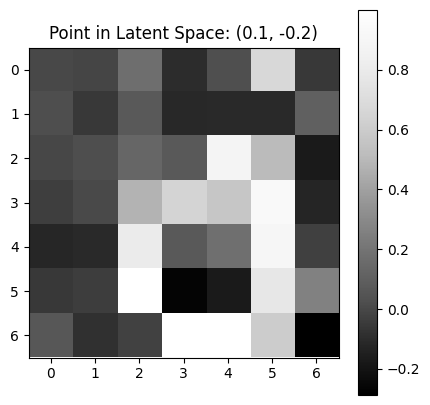

In [22]:
def plot_latent_point(decoder, x, y, digit_size=7, fig_size=5):
    z = np.array([[x, y]])
    output = decoder.forward(z)
    digit = output.reshape(digit_size, digit_size)

    plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(digit, cmap="Greys_r")
    plt.title(f"Point in Latent Space: ({x}, {y})")
    plt.colorbar()

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig(f"plots/latentpoint{timestamp}.png")


plot_latent_point(decoder, 0.1,-0.2)